In [1]:
import csv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pyslabgrid import mat as mat

In [2]:
def within_interfacezone(evlon, evlat):
    # test the interpolatiors
    hik_finterp = np.load('../01subduction-model/finterp/hik_finterp.npy', allow_pickle=True)[()]
    pbounds = hik_finterp['xbounds']
    if pbounds.contains(Point(evlon, evlat)):
        return 'hik'
    
    puy_finterp = np.load('../01subduction-model/finterp/puy_finterp.npy', allow_pickle=True)[()]
    pbounds = puy_finterp['xbounds']
    if pbounds.contains(Point(evlon, evlat)):
        return 'puy'
    
    return None

In [3]:
def is_slabevent(evlon, evlat, evdep, fixed_parameters = None):
    # Note that evdep is positive
    # for each event:
    #  if dep <= CRUST_THICKNESS && dep > interface_depth
    #       'NOT SLAB'
    #  if dep > 60 km
    #        'SLAB'
    #  if dep < 60 km & dep > interface_depth+buffer
    #     
    # (2) shallow_events, dep <= CRUST_THICKNESS
    # (3) define filter for interface buffer
    #     for events with dep <60 km, 
    # 
    
    evdep = abs(evdep)
    if fixed_parameters is None:
        fixed_parameters = {
                     'Hmax_interface': 80, # maximum depth
                     'interface_buffer': [10, 10],
                     'Hmax_crust': 40,
                     'min_depth': 0,
                     'max_depth': 500, # tentative
                 }
    #
    if evdep>fixed_parameters['Hmax_interface']:
        return True
    
    szone = within_interfacezone(evlon, evlat)
    if szone is None:
        return False
    else:
        if szone =='hik':
            dep_finterp = np.load('../01subduction-model/finterp/hik_finterp_lowerbounds.npy', \
                                  allow_pickle=True)[()]
        else:
            dep_finterp = np.load('../01subduction-model/finterp/puy_finterp_lowerbounds.npy', \
                                  allow_pickle=True)[()]
        lower_interface_depth = dep_finterp(np.transpose([[evlon], [evlat]]))
        if evdep<=lower_interface_depth:
            return False
        else:
            return True
        
def read_catalogue(input_file):
    # year, month, day, hour, minute, second, lon, lat, depth, mag
    eqcat = {}
    with open(input_file, "r") as f:
        datareader=csv.reader(f)
        header = next(datareader)
        nrow = 0
        lon, lat, dep, mag = [],[],[],[]
        year, month, day = [],[],[]
        for row in datareader:    
            year.append(int(row[0]))
            month.append(int(row[1]))
            day.append(int(row[2]))
            lon.append(float(row[6]))
            lat.append(float(row[7]))
            dep.append(float(row[8]))
            mag.append(float(row[9]))
        eqcat.update({'year': year, 'month':month, 'day':day,
                      'lon': lon, 'lat':lat, 'dep':dep,
                  'mag':mag})
        return eqcat

In [4]:
catalogues = ['NZeqcat_Rollins13042020-subd.csv',
             'Grue_NZeqcat_Rollins13042020SepiShallow_subd.csv',
             'Grue_NZeqcat_Rollins13042020SepiDeep-subd.csv',]
folder_catalogue = '../data/eqcat/subduction_catalogs/'

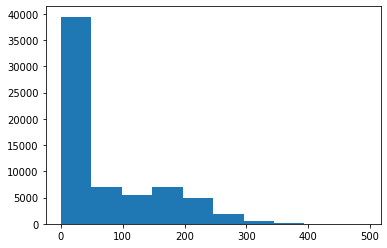

In [5]:
tcat = read_catalogue(folder_catalogue+catalogues[0])
plt.hist(tcat['dep']);

In [6]:
fixed_parameters = { 'Hmax_interface': 80, # maximum depth
                     'interface_buffer': [10, 10],
                     'Hmax_crust': 40,
                     'min_depth': 0,
                     'max_depth': 500,}
outfolder = 'classified_catalogs/'
for catalog in catalogues:
    eqcat = read_catalogue(folder_catalogue+catalog)
                    
    outfile = outfolder + catalog.split('.')[0] + '-slab.csv'
    fout = open(outfile, 'w') 
    fout.write('year, month, day, lon, lat, dep, mag, isslab')
    for lon, lat, dep, mag, yer, mon, dy \
             in zip(eqcat['lon'], eqcat['lat'], eqcat['dep'], \
                          eqcat['mag'], eqcat['year'], eqcat['month'], eqcat['day']):
        if mag<3.0:
            continue
            
        # trapped an event
        if (yer==2003) & (mon==8) & (dy==21) & (mag>=7.0):
            print('*** The rogue 2003 Puysegur event is unslabbed!!! ')
            fout.write('\n%d, %d, %d, %.4f, %.4f, %.4f, %.3f, 0' %(yer, mon, dy, lon, lat, dep, mag))
            continue;
        
        if is_slabevent(lon, lat, dep, fixed_parameters = fixed_parameters):
            fout.write('\n%d, %d, %d, %.4f, %.4f, %.4f, %.3f, 1' %(yer, mon, dy, lon, lat, dep, mag))
        else:
            fout.write('\n%d, %d, %d, %.4f, %.4f, %.4f, %.3f, 0' %(yer, mon, dy, lon, lat, dep, mag))
        
    fout.close()
    print('>>> FILE Exported: ' + outfile)

*** The rogue 2003 Puysegur event is unslabbed!!! 
>>> FILE Exported: classified_catalogs/NZeqcat_Rollins13042020-subd-slab.csv
*** The rogue 2003 Puysegur event is unslabbed!!! 
>>> FILE Exported: classified_catalogs/Grue_NZeqcat_Rollins13042020SepiShallow_subd-slab.csv
>>> FILE Exported: classified_catalogs/Grue_NZeqcat_Rollins13042020SepiDeep-subd-slab.csv
